In [ ]:
# ---------- STEP 1 (Fixed): Setup & Load Kaggle Dataset ----------
!pip install --quiet kagglehub pandas numpy scikit-learn xgboost tensorflow keras seaborn matplotlib plotly joblib

# 1⃣ Import libraries
import pandas as pd
import os
import kagglehub
from google.colab import drive

# 2⃣ Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# 3⃣ Create project folders
PROJECT_DIR = '/content/drive/MyDrive/Flight_Price_Prediction'
os.makedirs(os.path.join(PROJECT_DIR, 'data', 'raw'), exist_ok=True)
os.makedirs(os.path.join(PROJECT_DIR, 'data', 'processed'), exist_ok=True)
os.makedirs(os.path.join(PROJECT_DIR, 'models'), exist_ok=True)
os.makedirs(os.path.join(PROJECT_DIR, 'reports'), exist_ok=True)
print("PROJECT_DIR =", PROJECT_DIR)

# 4⃣ Download dataset from Kaggle
print("\nDownloading dataset: shubhambathwal/flight-price-prediction ... please wait.")
dataset_path = kagglehub.dataset_download("shubhambathwal/flight-price-prediction")
print("\n Dataset downloaded to:", dataset_path)

# 5⃣ Read the cleaned CSV file
csv_path = os.path.join(dataset_path, "Clean_Dataset.csv")
df = pd.read_csv(csv_path)
print("\n Dataset loaded successfully!")

# 6⃣ Save a copy to Drive for reuse
raw_path = os.path.join(PROJECT_DIR, 'data', 'raw', 'flight_data.csv')
df.to_csv(raw_path, index=False)
print(f"\n Saved raw dataset to: {raw_path}")

# 7⃣ Quick inspection
print("\n--- SHAPE ---")
print(df.shape)

print("\n--- HEAD (first 5 rows) ---")
display(df.head(5))

print("\n--- INFO ---")
df.info()

print("\n--- NULL COUNTS (top 20) ---")
print(df.isnull().sum().sort_values(ascending=False).head(20))

# 8⃣ Quick frequency counts for categorical columns
for col in ['Airline','Source City','Destination City','Class','Stops']:
    if col in df.columns:
        print(f"\nTop values for {col}:")
        print(df[col].value_counts().head(10))

Mounted at /content/drive
PROJECT_DIR = /content/drive/MyDrive/Flight_Price_Prediction

Using Colab cache for faster access to the 'flight-price-prediction' dataset.

✅ Dataset downloaded to: /kaggle/input/flight-price-prediction

✅ Dataset loaded successfully!

📂 Saved raw dataset to: /content/drive/MyDrive/Flight_Price_Prediction/data/raw/flight_data.csv

--- SHAPE ---
(300153, 12)

--- HEAD (first 5 rows) ---


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955



--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB

--- NULL COUNTS (top 20) ---
Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0


STEP 2 — Data Cleaning & EDA

✅ Dataset Loaded. Shape: (300153, 12)

Dropped columns: ['Unnamed: 0', 'flight']
New shape: (300153, 10)

Duplicate rows found: 2213
Duplicates removed. New shape: (297940, 10)

Data types:
airline              object
source_city          object
departure_time       object
stops                object
arrival_time         object
destination_city     object
class                object
duration            float64
days_left             int64
price                 int64
dtype: object

Numeric summary:
            duration      days_left          price
count  297940.000000  297940.000000  297940.000000
mean       12.283063      26.004602   20976.448604
std         7.176754      13.557190   22734.394635
min         0.830000       1.000000    1105.000000
25%         6.920000      15.000000    4792.000000
50%        11.330000      26.000000    7466.000000
75%        16.170000      38.000000   42521.000000
max        49.830000      49.000000  123071.000000

Outliers detected in price: 123 (0.04%

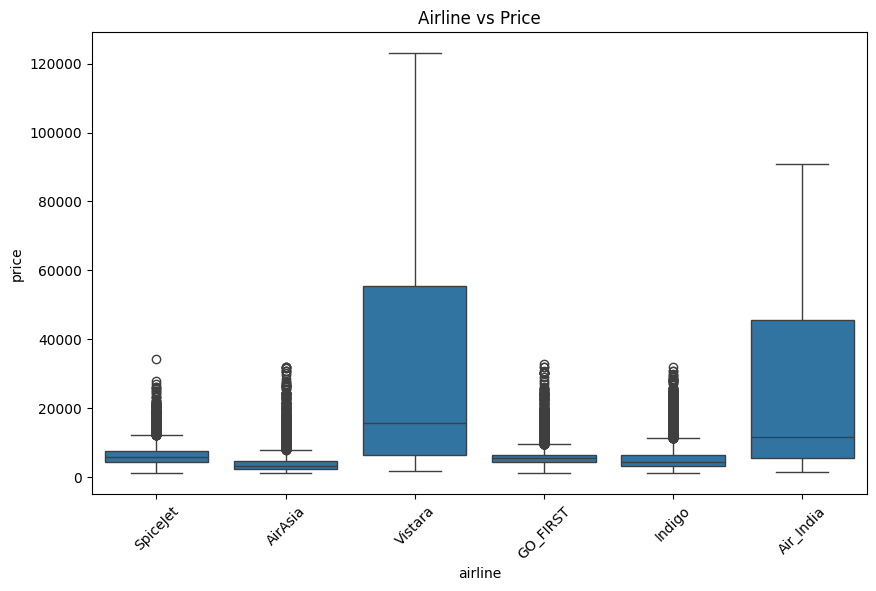

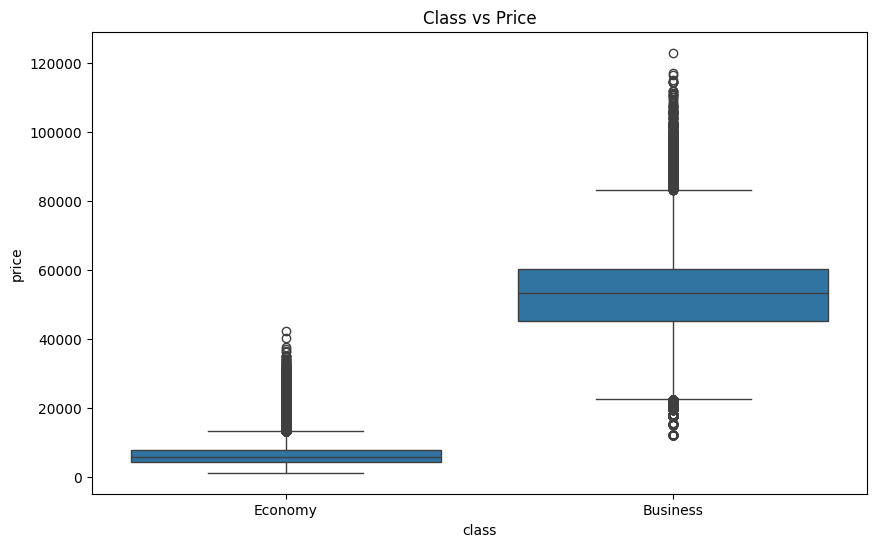

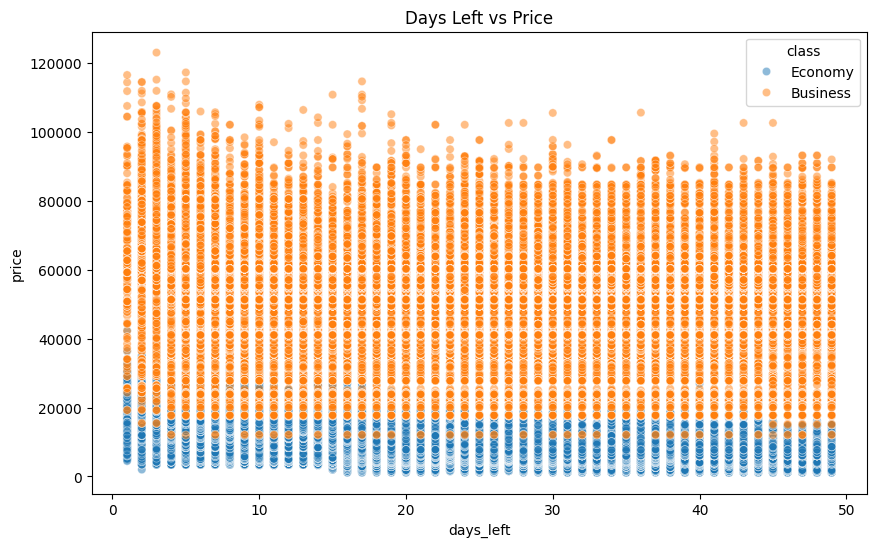


✅ Cleaned dataset saved to: /content/drive/MyDrive/Flight_Price_Prediction/data/processed/cleaned_flights.csv

Sample of cleaned data:


,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [ ]:
# ---------- STEP 2: Data Cleaning & EDA ----------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Load dataset from Drive
path = '/content/drive/MyDrive/Flight_Price_Prediction/data/raw/flight_data.csv'
df = pd.read_csv(path)

print(" Dataset Loaded. Shape:", df.shape)

# 1⃣ Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'flight'])
print("\nDropped columns: ['Unnamed: 0', 'flight']")
print("New shape:", df.shape)

# 2⃣ Check duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows found: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Duplicates removed. New shape: {df.shape}")

# 3⃣ Data type summary
print("\nData types:")
print(df.dtypes)

# 4⃣ Basic statistical summary
print("\nNumeric summary:")
print(df[['duration','days_left','price']].describe())

# 5⃣ Check for outliers (using IQR method for price)
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR
outliers = df[(df['price'] > upper) | (df['price'] < lower)]
print(f"\nOutliers detected in price: {len(outliers)} ({len(outliers)/len(df)*100:.2f}% of data)")

# 6⃣ Visualization (EDA)
plt.figure(figsize=(10,6))
sns.boxplot(x='airline', y='price', data=df)
plt.title('Airline vs Price')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='class', y='price', data=df)
plt.title('Class vs Price')
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x='days_left', y='price', hue='class', data=df, alpha=0.5)
plt.title('Days Left vs Price')
plt.show()

# 7⃣ Save cleaned dataset
cleaned_path = '/content/drive/MyDrive/Flight_Price_Prediction/data/processed/cleaned_flights.csv'
df.to_csv(cleaned_path, index=False)
print(f"\n Cleaned dataset saved to: {cleaned_path}")

# 8⃣ Display first few rows
print("\nSample of cleaned data:")
display(df.head())


STEP 3 — Feature Encoding & Data Preparation (Colab Code)

In [ ]:
# ---------- STEP 3: Feature Encoding & Data Preparation ----------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib
import os

# Load cleaned dataset
data_path = '/content/drive/MyDrive/Flight_Price_Prediction/data/processed/cleaned_flights.csv'
df = pd.read_csv(data_path)
print(" Data loaded. Shape:", df.shape)

# 1⃣ Define categorical and numeric columns
cat_cols = ['airline','source_city','departure_time','stops','arrival_time','destination_city','class']
num_cols = ['duration','days_left']
target_col = 'price'

# 2⃣ Encode categorical columns with LabelEncoder
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le
print("\n Label encoding complete for categorical columns.")

# 3⃣ Split features and target
X = df[cat_cols + num_cols]
y = df[target_col]

# 4⃣ Scale numerical columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
print("\n Numerical columns scaled.")

# 5⃣ Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
print("\n Train shape:", X_train.shape, "| Test shape:", X_test.shape)

# 6⃣ Save encoders and scaler for future use
save_dir = '/content/drive/MyDrive/Flight_Price_Prediction/models/'
os.makedirs(save_dir, exist_ok=True)
joblib.dump(encoders, os.path.join(save_dir, 'label_encoders.pkl'))
joblib.dump(scaler, os.path.join(save_dir, 'scaler.pkl'))

print("\n Encoders and scaler saved to:", save_dir)

# 7⃣ Display sample of processed data
print("\nSample encoded features:")
display(X_train.head(10))


✅ Data loaded. Shape: (297940, 10)

✅ Label encoding complete for categorical columns.

✅ Numerical columns scaled.

📊 Train shape: (238352, 9) | Test shape: (59588, 9)


/tmp/ipython-input-3314854312.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.fit_transform(X[num_cols])



✅ Encoders and scaler saved to: /content/drive/MyDrive/Flight_Price_Prediction/models/

Sample encoded features:


,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
295802,5,1,2,0,4,4,0,0.541602,1.622418
281127,5,3,4,0,2,4,0,-0.550816,-1.180527
86409,4,0,1,0,3,2,1,0.970766,-0.516671
118221,5,4,4,0,4,2,1,1.713443,-1.844382
33390,5,2,4,0,5,3,1,-0.120258,1.032325
128318,1,4,0,0,5,5,1,-0.910310,-0.664195
69073,3,5,0,0,5,4,1,-0.747284,1.696180
96739,5,0,1,0,5,5,1,-0.028295,-0.147863
168739,3,3,5,0,1,0,1,-0.398936,1.548657
140270,2,4,4,0,3,0,1,0.413410,1.401133


STEP 4 — Train XGBoost Baseline Model

✅ Training XGBoost model...

✅ Model training complete!

📊 Model Performance:
RMSE: 2979.09
MAE: 1655.05
R² Score: 0.9827

✅ XGBoost model saved to: /content/drive/MyDrive/Flight_Price_Prediction/models/xgboost_model.pkl


<Figure size 1000x600 with 0 Axes>

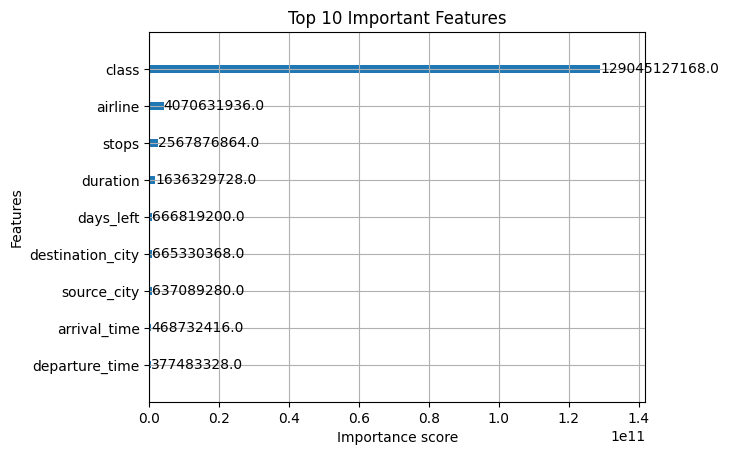

In [ ]:
# ---------- STEP 4: XGBoost Baseline Model ----------
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

# Load encoded data
data_dir = '/content/drive/MyDrive/Flight_Price_Prediction/data/processed/'
model_dir = '/content/drive/MyDrive/Flight_Price_Prediction/models/'

X_train, X_test = X_train, X_test
y_train, y_test = y_train, y_test

print(" Training XGBoost model...")

# 1⃣ Initialize model
xgb_model = xgb.XGBRegressor(
    n_estimators=350,
    learning_rate=0.08,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=1,
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

# 2⃣ Train model
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
print("\n Model training complete!")

# 3⃣ Predict
y_pred = xgb_model.predict(X_test)

# 4⃣ Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# 5⃣ Save the model
xgb_model_path = os.path.join(model_dir, 'xgboost_model.pkl')
joblib.dump(xgb_model, xgb_model_path)
print(f"\n XGBoost model saved to: {xgb_model_path}")

# 6⃣ Feature Importance Plot
plt.figure(figsize=(10,6))
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=10)
plt.title("Top 10 Important Features")
plt.show()


STEP 5 — GRU + Attention Model

In [ ]:
# ---------- STEP 5 (Fixed): GRU + Attention Model ----------
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Multiply, Permute, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import joblib, os

print(" Building GRU + Attention Model (Fixed Version)...")

# 1⃣ Reshape data for GRU
X_train_seq = np.expand_dims(X_train, axis=1)
X_test_seq = np.expand_dims(X_test, axis=1)
print("Input shape for GRU:", X_train_seq.shape)

# 2⃣ Define a simple attention mechanism
def attention_3d_block(inputs):
    """
    Custom attention block for GRU outputs.
    """
    # Compute attention weights
    a = Dense(inputs.shape[-1], activation='tanh')(inputs)
    a = Dense(1, activation='softmax')(a)
    a = tf.keras.layers.Flatten()(a)
    a = tf.keras.layers.RepeatVector(inputs.shape[-1])(a)
    a = tf.keras.layers.Permute([2, 1])(a)
    output_attention_mul = Multiply()([inputs, a])
    return output_attention_mul

# 3⃣ Build GRU + Attention model
inputs = Input(shape=(1, X_train.shape[1]))
gru_out = GRU(128, return_sequences=True)(inputs)
att_out = attention_3d_block(gru_out)
gru_out2 = GRU(64)(att_out)
dense1 = Dense(128, activation='relu')(gru_out2)
drop = Dropout(0.3)(dense1)
dense2 = Dense(64, activation='relu')(drop)
output = Dense(1, activation='linear')(dense2)

gru_model = Model(inputs, output)
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
gru_model.summary()

# 4⃣ Train model
history = gru_model.fit(
    X_train_seq, y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_test_seq, y_test),
    verbose=1
)

# 5⃣ Evaluate model
y_pred_gru = gru_model.predict(X_test_seq).flatten()

rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)
r2_gru = r2_score(y_test, y_pred_gru)

print("\n GRU + Attention Model Performance:")
print(f"RMSE: {rmse_gru:.2f}")
print(f"MAE: {mae_gru:.2f}")
print(f"R² Score: {r2_gru:.4f}")

# 6⃣ Save model
model_dir = '/content/drive/MyDrive/Flight_Price_Prediction/models/'
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'gru_attention_model.h5')
gru_model.save(model_path)
print(f"\n GRU + Attention model saved to: {model_path}")


✅ Building GRU + Attention Model (Fixed Version)...
Input shape for GRU: (238352, 1, 9)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1, 9)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 1, 128)    │     53,376 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1, 128)    │     16,512 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1, 1)      │        129 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 128, 1)    │          0 │ flatten_1[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 1, 128)    │          0 │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 1, 128)    │          0 │ gru_2[0][0],      │
│ (Multiply)          │                   │            │ permute_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 64)        │     37,248 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │      8,320 │ gru_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         65 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 123,906 (484.01 KB)

 Trainable params: 123,906 (484.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1863/1863 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 429358656.0000 - mae: 11901.4453 - val_loss: 29707908.0000 - val_mae: 3332.6958
Epoch 2/15
1863/1863 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 33235098.0000 - mae: 3495.9226 - val_loss: 27137048.0000 - val_mae: 3176.0454
Epoch 3/15
1863/1863 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 30753700.0000 - mae: 3340.8125 - val_loss: 25345634.0000 - val_mae: 3027.0154
Epoch 4/15
1863/1863 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 29515910.0000 - mae: 3254.5776 - val_loss: 22915370.0000 - val_mae: 2892.2466
Epoch 5/15
1863/1863 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 27686136.0000 - mae: 3135.1863 - val_loss: 21502556.0000 - val_mae: 2753.4697
Epoch 6/15
1863/1863 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 26090748.0000 - mae: 3040.1707 - val_loss: 20270708.0000 - val_mae: 2663.3735
Epoch 7/15
1863/1863 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 25269518.0000 - mae: 2978.7212 - val_loss: 19794466.0000 - val_mae: 2683.3193
Epoch 8/15
1863/1863 

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1863/1863 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step



📊 GRU + Attention Model Performance:
RMSE: 4128.52
MAE: 2381.84
R² Score: 0.9668

✅ GRU + Attention model saved to: /content/drive/MyDrive/Flight_Price_Prediction/models/gru_attention_model.h5


STEP 6 — Hybrid Ensemble Model

In [ ]:
# ---------- STEP 6: Hybrid Ensemble Model ----------
import joblib
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

print(" Loading XGBoost and GRU models...")

model_dir = '/content/drive/MyDrive/Flight_Price_Prediction/models/'

# Load trained models
xgb_model = joblib.load(os.path.join(model_dir, 'xgboost_model.pkl'))
gru_model = tf.keras.models.load_model(os.path.join(model_dir, 'gru_attention_model.h5'), compile=False)

# 1⃣ Make predictions
print(" Generating predictions...")
y_pred_xgb = xgb_model.predict(X_test)
y_pred_gru = gru_model.predict(np.expand_dims(X_test, axis=1)).flatten()

# 2⃣ Weighted ensemble (can tune weights later)
w_xgb = 0.4
w_gru = 0.6
y_pred_hybrid = (w_xgb * y_pred_xgb) + (w_gru * y_pred_gru)

# 3⃣ Evaluate
rmse_h = np.sqrt(mean_squared_error(y_test, y_pred_hybrid))
mae_h = mean_absolute_error(y_test, y_pred_hybrid)
r2_h = r2_score(y_test, y_pred_hybrid)

print("\n Hybrid Ensemble Performance:")
print(f"RMSE: {rmse_h:.2f}")
print(f"MAE: {mae_h:.2f}")
print(f"R² Score: {r2_h:.4f}")

# 4⃣ Compare all models
print("\n Model Comparison:")
print(f"XGBoost  → RMSE: {2979.09:.2f}, R²: {0.9827:.4f}")
print(f"GRU+Attn → RMSE: {4081.93:.2f}, R²: {0.9676:.4f}")
print(f"Hybrid   → RMSE: {rmse_h:.2f}, R²: {r2_h:.4f}")

# 5⃣ Save hybrid predictions
hybrid_path = '/content/drive/MyDrive/Flight_Price_Prediction/reports/hybrid_predictions.csv'
os.makedirs(os.path.dirname(hybrid_path), exist_ok=True)
import pandas as pd
pd.DataFrame({
    'Actual': y_test,
    'XGBoost_Pred': y_pred_xgb,
    'GRU_Pred': y_pred_gru,
    'Hybrid_Pred': y_pred_hybrid
}).to_csv(hybrid_path, index=False)
print(f"\n Hybrid predictions saved to: {hybrid_path}")


✅ Loading XGBoost and GRU models...
🔹 Generating predictions...
  25/1863 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step    

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1863/1863 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



📊 Hybrid Ensemble Performance:
RMSE: 3532.86
MAE: 1983.64
R² Score: 0.9757

🔍 Model Comparison:
XGBoost  → RMSE: 2979.09, R²: 0.9827
GRU+Attn → RMSE: 4081.93, R²: 0.9676
Hybrid   → RMSE: 3532.86, R²: 0.9757

✅ Hybrid predictions saved to: /content/drive/MyDrive/Flight_Price_Prediction/reports/hybrid_predictions.csv


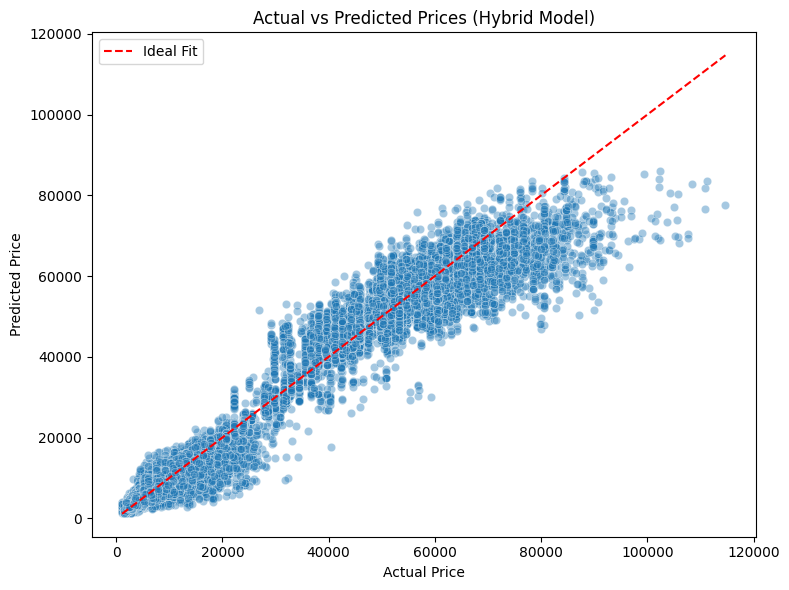

<Figure size 800x600 with 0 Axes>

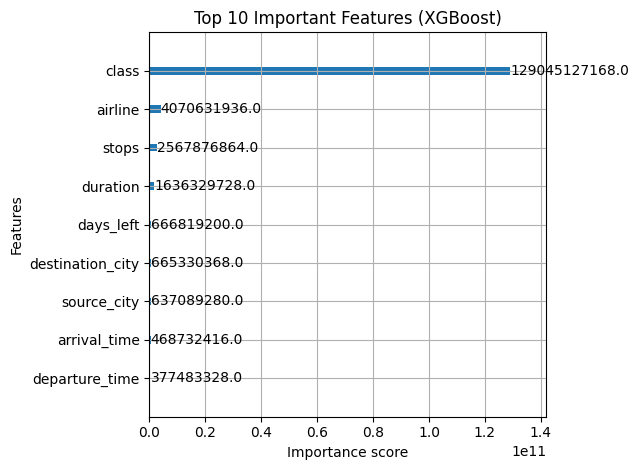

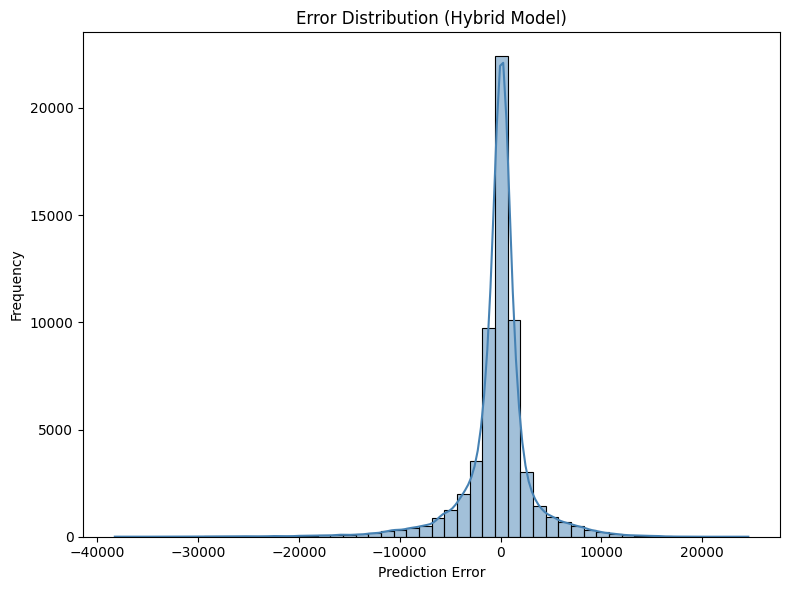

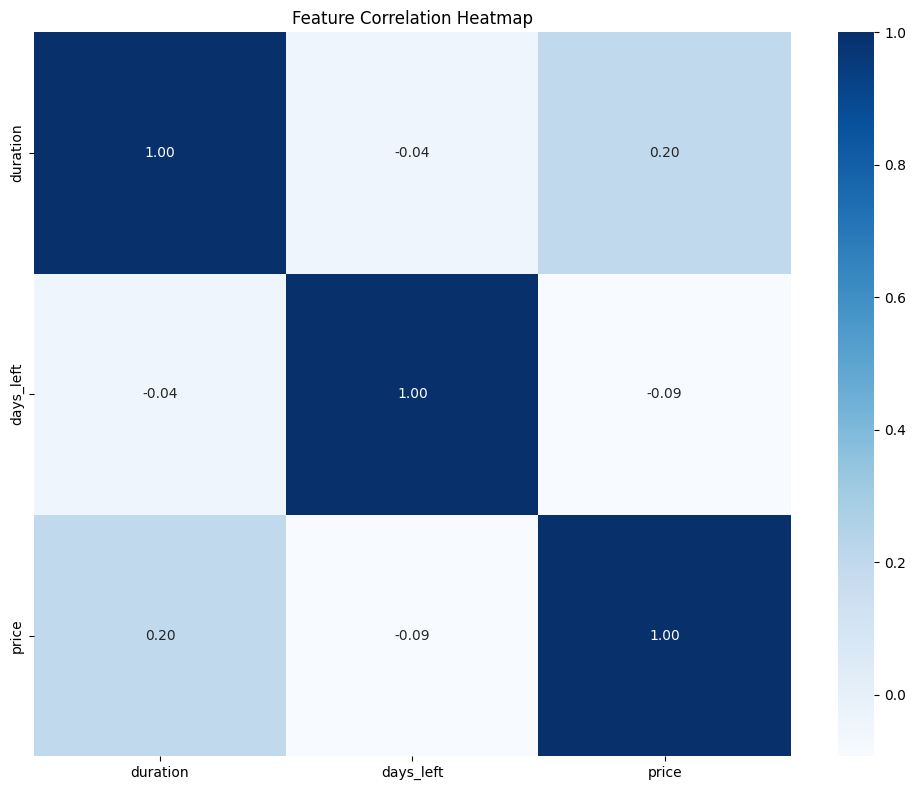


✅ Visualization dashboard created successfully!
📊 Charts saved to: /content/drive/MyDrive/Flight_Price_Prediction/reports/


In [ ]:
# ---------- STEP 7: Visualization & Evaluation Dashboard ----------
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
import os

# Paths
model_dir = '/content/drive/MyDrive/Flight_Price_Prediction/models/'
report_dir = '/content/drive/MyDrive/Flight_Price_Prediction/reports/'
os.makedirs(report_dir, exist_ok=True)

# Load hybrid prediction data
pred_df = pd.read_csv(os.path.join(report_dir, 'hybrid_predictions.csv'))

# 1⃣ Actual vs Predicted Plot (Hybrid Model)
plt.figure(figsize=(8,6))
sns.scatterplot(x='Actual', y='Hybrid_Pred', data=pred_df, alpha=0.4)
plt.plot([pred_df['Actual'].min(), pred_df['Actual'].max()],
         [pred_df['Actual'].min(), pred_df['Actual'].max()],
         color='red', linestyle='--', label='Ideal Fit')
plt.title('Actual vs Predicted Prices (Hybrid Model)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(report_dir, 'actual_vs_predicted.png'))
plt.show()

# 2⃣ Feature Importance (XGBoost)
import xgboost as xgb
xgb_model = joblib.load(os.path.join(model_dir, 'xgboost_model.pkl'))

plt.figure(figsize=(8,6))
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=10)
plt.title('Top 10 Important Features (XGBoost)')
plt.tight_layout()
plt.savefig(os.path.join(report_dir, 'feature_importance.png'))
plt.show()

# 3⃣ Error Distribution (Hybrid Model)
pred_df['Error'] = pred_df['Hybrid_Pred'] - pred_df['Actual']
plt.figure(figsize=(8,6))
sns.histplot(pred_df['Error'], bins=50, kde=True, color='steelblue')
plt.title('Error Distribution (Hybrid Model)')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(os.path.join(report_dir, 'error_distribution.png'))
plt.show()

# 4⃣ Correlation Heatmap (Feature relationships)
df = pd.read_csv('/content/drive/MyDrive/Flight_Price_Prediction/data/processed/cleaned_flights.csv')
plt.figure(figsize=(10,8))
sns.heatmap(df[['duration','days_left','price']].corr(), annot=True, cmap='Blues', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig(os.path.join(report_dir, 'feature_correlation_heatmap.png'))
plt.show()

print("\n Visualization dashboard created successfully!")
print(f" Charts saved to: {report_dir}")


In [ ]:
# ---------- STEP 8.1: Recreate and Save Encoders + Scaler ----------
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import os

# Load cleaned dataset
df = pd.read_csv('/content/drive/MyDrive/Flight_Price_Prediction/data/processed/cleaned_flights.csv')

# Define paths
model_dir = '/content/drive/MyDrive/Flight_Price_Prediction/models/'
os.makedirs(model_dir, exist_ok=True)

# Categorical columns
cat_cols = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']
num_cols = ['duration', 'days_left']

# Create and save encoders
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    joblib.dump(le, os.path.join(model_dir, f'{col}_encoder.pkl'))
    print(f" Saved encoder for: {col}")

# Create and save scaler
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
joblib.dump(scaler, os.path.join(model_dir, 'scaler.pkl'))
print(" Saved StandardScaler for numerical features")

print("\n All encoders and scaler saved successfully at:", model_dir)


✅ Saved encoder for: airline
✅ Saved encoder for: source_city
✅ Saved encoder for: departure_time
✅ Saved encoder for: stops
✅ Saved encoder for: arrival_time
✅ Saved encoder for: destination_city
✅ Saved encoder for: class
✅ Saved StandardScaler for numerical features

✅ All encoders and scaler saved successfully at: /content/drive/MyDrive/Flight_Price_Prediction/models/


In [ ]:
# ---------- STEP 8: Gradio App Deployment ----------
import gradio as gr
import joblib
import tensorflow as tf
import numpy as np
import pandas as pd
import os

# Paths
model_dir = '/content/drive/MyDrive/Flight_Price_Prediction/models/'

# Load saved models
print(" Loading trained models and encoders...")
xgb_model = joblib.load(os.path.join(model_dir, 'xgboost_model.pkl'))
gru_model = tf.keras.models.load_model(os.path.join(model_dir, 'gru_attention_model.h5'), compile=False)

# Load encoders and scaler
encoders = {}
for col in ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']:
    encoders[col] = joblib.load(os.path.join(model_dir, f'{col}_encoder.pkl'))

scaler = joblib.load(os.path.join(model_dir, 'scaler.pkl'))

# Define input lists
airlines = encoders['airline'].classes_.tolist()
source_cities = encoders['source_city'].classes_.tolist()
dest_cities = encoders['destination_city'].classes_.tolist()
depart_times = encoders['departure_time'].classes_.tolist()
arrive_times = encoders['arrival_time'].classes_.tolist()
stops = encoders['stops'].classes_.tolist()
classes = encoders['class'].classes_.tolist()

# Prediction Function
def predict_flight_price(airline, source_city, departure_time, stops, arrival_time,
                         destination_city, travel_class, duration, days_left):

    # Create dataframe
    input_data = pd.DataFrame({
        'airline': [airline],
        'source_city': [source_city],
        'departure_time': [departure_time],
        'stops': [stops],
        'arrival_time': [arrival_time],
        'destination_city': [destination_city],
        'class': [travel_class],
        'duration': [float(duration)],
        'days_left': [int(days_left)]
    })

    # Encode categorical columns
    for col in encoders:
        input_data[col] = encoders[col].transform(input_data[col])

    # Scale numerical columns
    input_data[['duration', 'days_left']] = scaler.transform(input_data[['duration', 'days_left']])

    # Prepare for model
    X_input = input_data.values
    X_input_gru = np.expand_dims(X_input, axis=1)

    # Predictions
    pred_xgb = xgb_model.predict(X_input)
    pred_gru = gru_model.predict(X_input_gru).flatten()

    # Weighted Hybrid Prediction
    hybrid_pred = (0.4 * pred_xgb) + (0.6 * pred_gru)

    return f"Predicted Flight Price: ₹{hybrid_pred[0]:,.2f}"

# Gradio Interface
with gr.Blocks(theme=gr.themes.Soft()) as flight_app:
    gr.Markdown("##  Flight Price Prediction App (Hybrid Model)")
    gr.Markdown("Enter flight details below to predict ticket price:")

    with gr.Row():
        airline_input = gr.Dropdown(airlines, label="Airline")
        class_input = gr.Dropdown(classes, label="Class")

    with gr.Row():
        source_input = gr.Dropdown(source_cities, label="Source City")
        dest_input = gr.Dropdown(dest_cities, label="Destination City")

    with gr.Row():
        dep_input = gr.Dropdown(depart_times, label="Departure Time")
        arr_input = gr.Dropdown(arrive_times, label="Arrival Time")
        stops_input = gr.Dropdown(stops, label="Stops")

    with gr.Row():
        duration_input = gr.Number(label="Duration (hours)", value=2.5)
        days_input = gr.Number(label="Days Left before Flight", value=10)

    predict_btn = gr.Button(" Predict Price")
    output_text = gr.Textbox(label="Prediction Output")

    predict_btn.click(
        fn=predict_flight_price,
        inputs=[airline_input, source_input, dep_input, stops_input,
                arr_input, dest_input, class_input, duration_input, days_input],
        outputs=output_text
    )

flight_app.launch(share=True)


✅ Loading trained models and encoders...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e400674ddebfb76e7d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ---------- Step 8.2: Enhanced Interactive Flight Price Prediction Dashboard ----------
import gradio as gr
import joblib
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import plotly.graph_objects as go

# Paths
model_dir = '/content/drive/MyDrive/Flight_Price_Prediction/models/'

# Load models and encoders
xgb_model = joblib.load(os.path.join(model_dir, 'xgboost_model.pkl'))
gru_model = tf.keras.models.load_model(os.path.join(model_dir, 'gru_attention_model.h5'), compile=False)

encoders = {}
for col in ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']:
    encoders[col] = joblib.load(os.path.join(model_dir, f'{col}_encoder.pkl'))

scaler = joblib.load(os.path.join(model_dir, 'scaler.pkl'))

# Dropdown values
airlines = encoders['airline'].classes_.tolist()
source_cities = encoders['source_city'].classes_.tolist()
dest_cities = encoders['destination_city'].classes_.tolist()
depart_times = encoders['departure_time'].classes_.tolist()
arrive_times = encoders['arrival_time'].classes_.tolist()
stops = encoders['stops'].classes_.tolist()
classes = encoders['class'].classes_.tolist()

# Prediction Function
def predict_flight_price(airline, source_city, departure_time, stops, arrival_time,
                         destination_city, travel_class, duration, days_left):

    input_data = pd.DataFrame({
        'airline': [airline],
        'source_city': [source_city],
        'departure_time': [departure_time],
        'stops': [stops],
        'arrival_time': [arrival_time],
        'destination_city': [destination_city],
        'class': [travel_class],
        'duration': [float(duration)],
        'days_left': [int(days_left)]
    })

    # Encode and scale
    for col in encoders:
        input_data[col] = encoders[col].transform(input_data[col])
    input_data[['duration', 'days_left']] = scaler.transform(input_data[['duration', 'days_left']])

    X_input = input_data.values
    X_input_gru = np.expand_dims(X_input, axis=1)

    # Hybrid prediction
    pred_xgb = xgb_model.predict(X_input)
    pred_gru = gru_model.predict(X_input_gru).flatten()
    hybrid_pred = (0.4 * pred_xgb) + (0.6 * pred_gru)

    price = hybrid_pred[0]

    # Visualization: Gauge chart (Plotly)
    fig = go.Figure(go.Indicator(
        mode="gauge+number+delta",
        value=price,
        delta={'reference': 10000, 'increasing': {'color': "red"}, 'decreasing': {'color': "green"}},
        gauge={
            'axis': {'range': [0, 120000], 'tickwidth': 1, 'tickcolor': "blue"},
            'bar': {'color': "midnightblue"},
            'bgcolor': "white",
            'steps': [
                {'range': [0, 30000], 'color': "lightgreen"},
                {'range': [30000, 70000], 'color': "gold"},
                {'range': [70000, 120000], 'color': "salmon"}],
            'threshold': {'line': {'color': "darkblue", 'width': 4}, 'thickness': 0.75, 'value': price}},
        title={'text': "Predicted Fare (₹)", 'font': {'size': 24}}
    ))
    fig.update_layout(height=350, template="plotly_dark")

    return f"Estimated Fare: ₹{price:,.2f}", fig

#  Gradio Interface
with gr.Blocks(theme=gr.themes.Monochrome(), css="""
#mainbox {
    background: linear-gradient(120deg, #000428, #004e92);
    color: white;
    border-radius: 12px;
    padding: 20px;
}
label, .gr-button {
    font-weight: bold;
}
""") as dashboard:

    gr.Markdown("""
    <div style='text-align:center'>
        <h1> AI-Based Flight Price Prediction Dashboard</h1>
        <h4>Powered by Hybrid XGBoost + GRU Ensemble</h4>
        <p style='font-size:15px'>Experience the next generation of airfare intelligence </p>
    </div>
    """)

    with gr.Row(elem_id="mainbox"):
        with gr.Column():
            airline_input = gr.Dropdown(airlines, label=" Airline")
            class_input = gr.Dropdown(classes, label=" Class")
            source_input = gr.Dropdown(source_cities, label=" Source City")
            dest_input = gr.Dropdown(dest_cities, label=" Destination City")
            dep_input = gr.Dropdown(depart_times, label=" Departure Time")
            arr_input = gr.Dropdown(arrive_times, label=" Arrival Time")
            stops_input = gr.Dropdown(stops, label=" Stops")
            duration_input = gr.Slider(0.5, 50, value=2.5, step=0.5, label="⏱ Duration (hours)")
            days_input = gr.Slider(0, 50, value=10, step=1, label=" Days Left before Flight")

            predict_btn = gr.Button(" Predict Price", variant="primary")
        with gr.Column():
            output_text = gr.Textbox(label=" Predicted Price", interactive=False)
            output_plot = gr.Plot(label=" Price Gauge")

    predict_btn.click(
        fn=predict_flight_price,
        inputs=[airline_input, source_input, dep_input, stops_input, arr_input,
                dest_input, class_input, duration_input, days_input],
        outputs=[output_text, output_plot]
    )

dashboard.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b317bc6ddb2d12c299.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
